In [259]:
import random
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

class Cuadrado():
    def __init__(self, dimensiones = 50, p = 0.45, pared=4, cueva = 5, semilla = None):
        self.semilla = semilla if semilla is not None else random.randint(0, 2**32 - 1)
        random.seed(semilla)
        self.dimensiones = dimensiones
        self.pared = pared
        self.cueva = cueva
        self.mapa = [[True if random.random() < p else False for _ in range(dimensiones)] for _ in range(dimensiones)]
    
    def pintar_mapa(self):
        # Crear un colormap personalizado donde True será azul oscuro y False será negro
        cmap = mcolors.ListedColormap(['black', 'darkblue'])
        
        plt.figure(figsize=(5, 5))
        plt.imshow(self.mapa, cmap=cmap, interpolation="nearest")
        plt.axis("off")
        plt.show()
    
    def paso_de_simulacion(self):
        temp_mapa = [[None for _ in range(self.dimensiones)] for _ in range(self.dimensiones)]
        for x in range(self.dimensiones):
            for y in range(self.dimensiones):
                vecinos_vivos = self.contar_vecinos_vivos(x, y)
                if self.mapa[x][y]:
                    if vecinos_vivos < self.pared:
                        temp_mapa[x][y] = False
                    else:
                        temp_mapa[x][y] = True
                else:
                    if vecinos_vivos > self.cueva:
                        temp_mapa[x][y] = True
                    else:
                        temp_mapa[x][y] = False
        
        self.mapa = temp_mapa
    def contar_vecinos_vivos(self, x, y):
        '''
            x-1 x x+1
        y-1  #  #  #
         y   #  x  #
        y+1  #  #  #
        '''
        count = 0
        for i in range(-1,2):
            for j in range(-1,2):
                vecino_x = x+i
                vecino_y = y+j
                # No queremos contarnos a nosotros mmismos
                if i == 0 and j == 0:
                    continue
                # Para rellenar los bordes de la cueva, esto puede aplicarse.
                elif vecino_x < 0 or vecino_y < 0 or vecino_x >= self.dimensiones or vecino_y >= self.dimensiones:
                    count += 1
                elif self.mapa[vecino_x][vecino_y]:
                    count += 1
        return count

In [260]:
def automata_celular(iteraciones = 4,dimensiones = 50, p = 0.45, pared = 4, cueva = 5, semilla = None):
    mapa = Cuadrado(dimensiones=dimensiones, p = p, pared = pared, cueva = cueva, semilla = semilla)
    for _ in range(iteraciones):
        mapa.paso_de_simulacion()
    mapa.pintar_mapa()

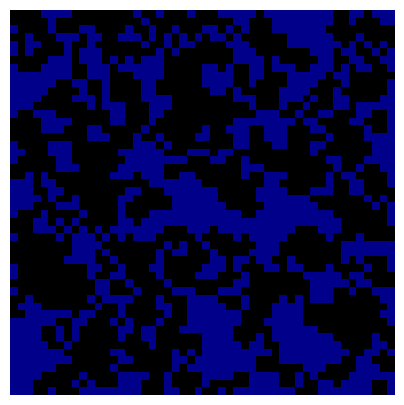

In [344]:
iteraciones = 7
dimensiones = 50
p = 0.4
pared = 2
cueva = 5
semilla = None
automata_celular(iteraciones=iteraciones, dimensiones=dimensiones, p=p, pared=pared, cueva=cueva, semilla=semilla)